Technological Institute of the Philippines | Quezon City - Computer Engineering
--- | ---
Course Code: | CPE 313
Code Title: | Advanced Machine Learning and Deep Learning
2nd Semester | AY 2025-2026
<u>**Assessment Task 4.1** | **Supplementary Activity on Transfer Learning**
**Name** | Adrian Justin Bulambao
**Section** | CPE32S3
**Date Performed**: | February 23, 2026
**Date Submitted**: | Fenruary 23, 2026
**Instructor**: | Engr. Neal Barton James Matira


### Loading Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

## Using the procedures to set up the training

In [13]:
data_transforms = {
    'Train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.Normalize([0.5], [0.5])
    ]),
    'Test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    ]),
}

data_dir = 'Dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['Train', 'Test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['Train', 'Test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['Train', 'Test']}
class_names = image_datasets['Train'].classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


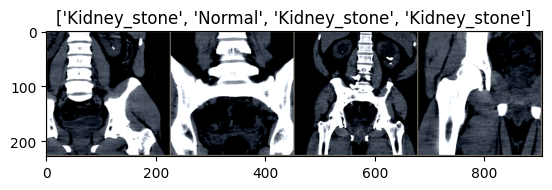

In [14]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['Train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

From the output, it can be seen that I am using an mri scan of kidneys to know if a kidney has a kidney stone or it is normal.

In [15]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()


    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)


            for phase in ['Train', 'Test']:
                if phase == 'Train':
                    model.train()  
                else:
                    model.eval()   

                running_loss = 0.0
                running_corrects = 0


                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)


                    optimizer.zero_grad()


                    with torch.set_grad_enabled(phase == 'Train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'Train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'Train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')


                if phase == 'Test' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')


        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

In [16]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['Test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### Using resnet18 first

In [17]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

#### training the model

In [18]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=25)

Epoch 0/24
----------
Train Loss: 0.6661 Acc: 0.6889
Test Loss: 0.2926 Acc: 0.8815

Epoch 1/24
----------
Train Loss: 0.5528 Acc: 0.7619
Test Loss: 0.1720 Acc: 0.9451

Epoch 2/24
----------
Train Loss: 0.5101 Acc: 0.7997
Test Loss: 0.2090 Acc: 0.9335

Epoch 3/24
----------
Train Loss: 0.4749 Acc: 0.8114
Test Loss: 0.1711 Acc: 0.9595

Epoch 4/24
----------
Train Loss: 0.3636 Acc: 0.8431
Test Loss: 0.2537 Acc: 0.9827

Epoch 5/24
----------
Train Loss: 0.3823 Acc: 0.8211
Test Loss: 0.1024 Acc: 0.9682

Epoch 6/24
----------
Train Loss: 0.3356 Acc: 0.8520
Test Loss: 0.1989 Acc: 0.9538

Epoch 7/24
----------
Train Loss: 0.2997 Acc: 0.8555
Test Loss: 0.1875 Acc: 0.9624

Epoch 8/24
----------
Train Loss: 0.2512 Acc: 0.8919
Test Loss: 0.1286 Acc: 0.9653

Epoch 9/24
----------
Train Loss: 0.2424 Acc: 0.8947
Test Loss: 0.1694 Acc: 0.9711

Epoch 10/24
----------
Train Loss: 0.2520 Acc: 0.8844
Test Loss: 0.1481 Acc: 0.9682

Epoch 11/24
----------
Train Loss: 0.2501 Acc: 0.8851
Test Loss: 0.1786 Acc

The best accuracy it got is 98.26% I will now visulize the model

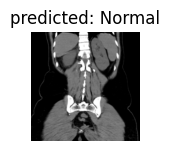

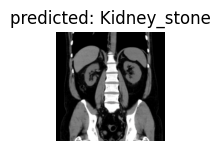

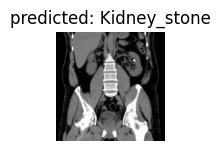

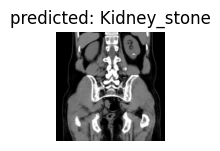

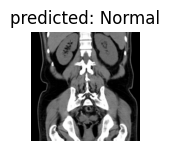

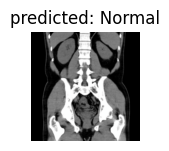

In [8]:
visualize_model(model_ft)

### I will now try using feature extractor

In [9]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()


optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [10]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
Train Loss: 0.7762 Acc: 0.5444
Test Loss: 0.8570 Acc: 0.5434

Epoch 1/24
----------
Train Loss: 0.7333 Acc: 0.6125
Test Loss: 2.0842 Acc: 0.5231

Epoch 2/24
----------
Train Loss: 0.7635 Acc: 0.6050
Test Loss: 1.4033 Acc: 0.5145

Epoch 3/24
----------
Train Loss: 0.7179 Acc: 0.6263
Test Loss: 1.4508 Acc: 0.5202

Epoch 4/24
----------
Train Loss: 0.7296 Acc: 0.6056
Test Loss: 0.7960 Acc: 0.5896

Epoch 5/24
----------
Train Loss: 0.7551 Acc: 0.6449
Test Loss: 1.5600 Acc: 0.5231

Epoch 6/24
----------
Train Loss: 0.7390 Acc: 0.6304
Test Loss: 0.7317 Acc: 0.5925

Epoch 7/24
----------
Train Loss: 0.6427 Acc: 0.6676
Test Loss: 0.9956 Acc: 0.5491

Epoch 8/24
----------
Train Loss: 0.6523 Acc: 0.6545
Test Loss: 1.1965 Acc: 0.5260

Epoch 9/24
----------
Train Loss: 0.6293 Acc: 0.6579
Test Loss: 0.8744 Acc: 0.5694

Epoch 10/24
----------
Train Loss: 0.6133 Acc: 0.6662
Test Loss: 0.9606 Acc: 0.5462

Epoch 11/24
----------
Train Loss: 0.6339 Acc: 0.6683
Test Loss: 0.9322 Acc

#### The model was much worse than the initial one, it only got a 59.24% accuracy, this might be because all the conv layers were not allowed to update and only relied on the imagenet to learn, which is not suitable for grayscale images like the mri scans.

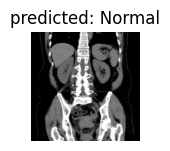

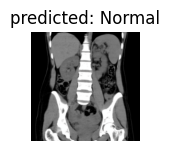

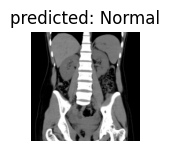

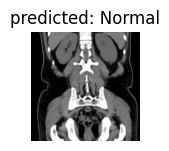

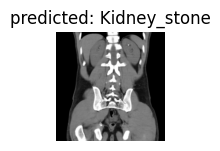

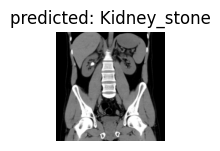

In [43]:
visualize_model(model_conv)

### Since I am using a black and white image it will be a [1,224,224] channel and will result in an error when using the model visualization function

In [ ]:
data_transforms = {
    'Train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        #transforms.Lambda(lambda img: img.convert("RGB")), <-- could also be used 
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) <-- needed when converting to to rgb
        transforms.Normalize([0.5], [0.5])  #I am using a black and white I will be adding this to turn it to one channel


    ]),
    'Test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        #transforms.Lambda(lambda img: img.convert("RGB")), <-- could also be used 
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) <-- needed when converting to to rgb
        transforms.Normalize([0.5], [0.5])  #I am using a black and white I will be adding this to turn it to one channel
    ]),
}

In [52]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['Test'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

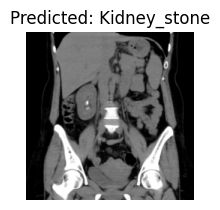

In [ ]:
visualize_model_predictions(
    model_conv,
    img_path=r'Dataset\Test\Kidney_stone\1.3.46.670589.33.1.63713381201930036800001.4827992095518766847.png')
# this must return that the output is "Kidney_stone"

plt.ioff()
plt.show()

# Conclusion

From this assessment task, I was able to use transfer learning on something other than classifying animals, I used it on an MRI scan of kidneys, the initial model was able to reach a high accuracy score as it allows all the layers to update as it trains, meaning the features of the imagenet was adapting to the MRI scan dataset. While in the feature extraction model, it wasn't able to get a high accuracy, as the layers were prevented from updating and only relied on the imagenet features, that was not suited for grayscale images like the MRI scan.   